Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [5]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import datasets, layers
from tensorflow.keras.models import Sequential

In [6]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [7]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [8]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [9]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [10]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='categorical',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.


In [11]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    labels='inferred',
    label_mode='categorical',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [12]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

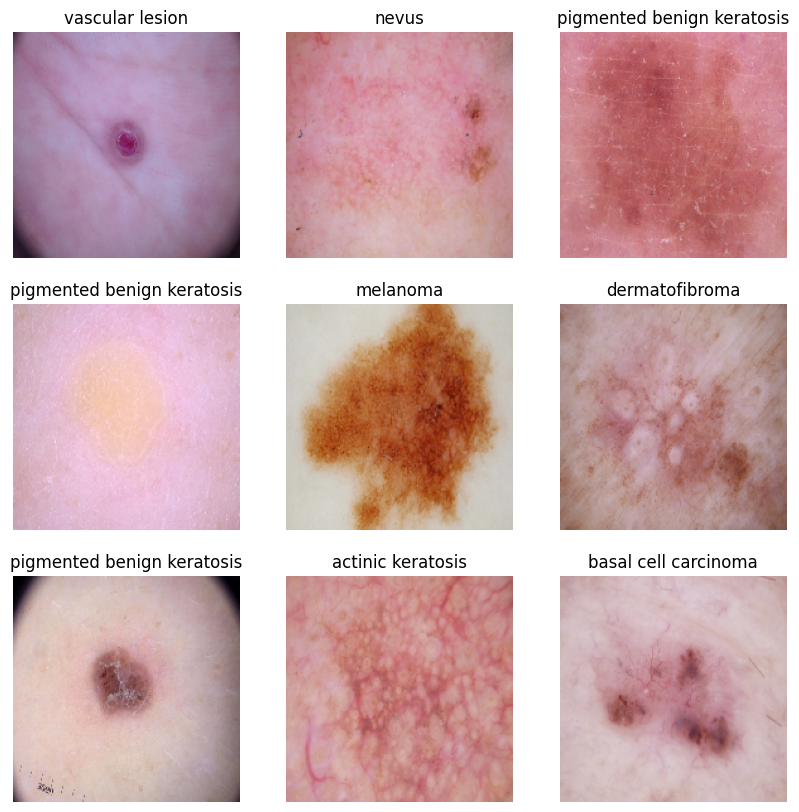

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [15]:
num_classes = 9

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [16]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 7744)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         991,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,017,401 (3.88 MB)

 Trainable params: 1,017,401 (3.88 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [18]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 383s 694ms/step - accuracy: 0.2320 - loss: 2.0521 - val_accuracy: 0.1780 - val_loss: 2.2101
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.2876 - loss: 1.9182 - val_accuracy: 0.2542 - val_loss: 2.1642
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.4134 - loss: 1.6543 - val_accuracy: 0.2881 - val_loss: 2.2632
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.4979 - loss: 1.4402 - val_accuracy: 0.2881 - val_loss: 2.0870
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5017 - loss: 1.4164 - val_accuracy: 0.3390 - val_loss: 2.3434
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5361 - loss: 1.3109 - val_accuracy: 0.2712 - val_loss: 2.3750
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5727 - loss: 1.2319 - val_accuracy: 0.3051 - val_loss: 2.5860
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5663 - loss: 1.1936 - val_accuracy: 0.3051 

### Visualizing training results

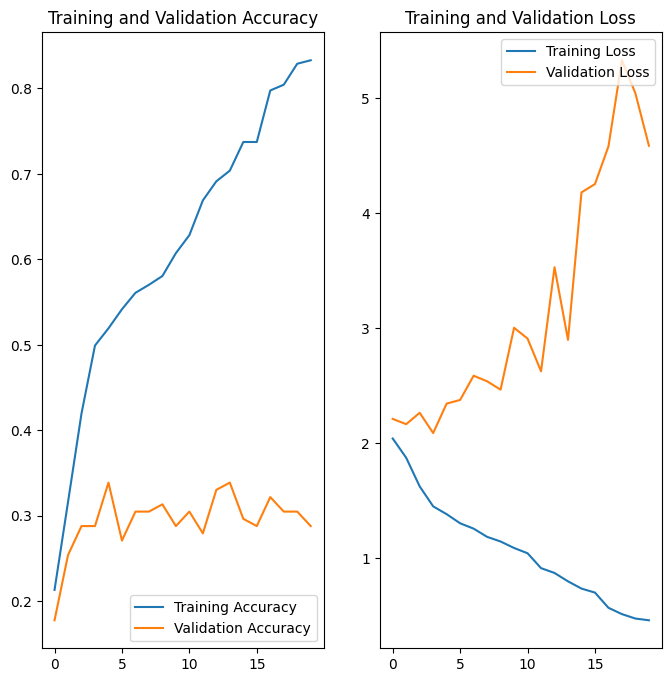

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit

The training accuracy is increasing linearly, while the validation accuracy flattens out after a few epochs.

This indicates model is overfitting. Model is learning the training data very well but not able to predict the unseen data effectively.

In [20]:
# Data augmentation strategy: Apply random horizontal flips, random rotations, and random zoom to the training dataset

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

# Re-compile and train the model with data augmentation
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Apply data augmentation to the training dataset
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# Train the model again
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 23s 300ms/step - accuracy: 0.5149 - loss: 1.4622 - val_accuracy: 0.3644 - val_loss: 2.8696
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 232ms/step - accuracy: 0.5746 - loss: 1.1885 - val_accuracy: 0.3220 - val_loss: 2.3832
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 232ms/step - accuracy: 0.6102 - loss: 1.1128 - val_accuracy: 0.3644 - val_loss: 2.7223
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 17s 243ms/step - accuracy: 0.6311 - loss: 1.0752 - val_accuracy: 0.3729 - val_loss: 2.8561
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 266ms/step - accuracy: 0.6144 - loss: 1.0681 - val_accuracy: 0.3475 - val_loss: 2.5562
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 17s 243ms/step - accuracy: 0.6296 - loss: 1.0702 - val_accuracy: 0.3390 - val_loss: 2.3066
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 234ms/step - accuracy: 0.6408 - loss: 1.0139 - val_accuracy: 0.3475 - val_loss: 2.6469
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 17s 236ms/step - accuracy: 0.6477 - loss: 0.9909 - val_accu

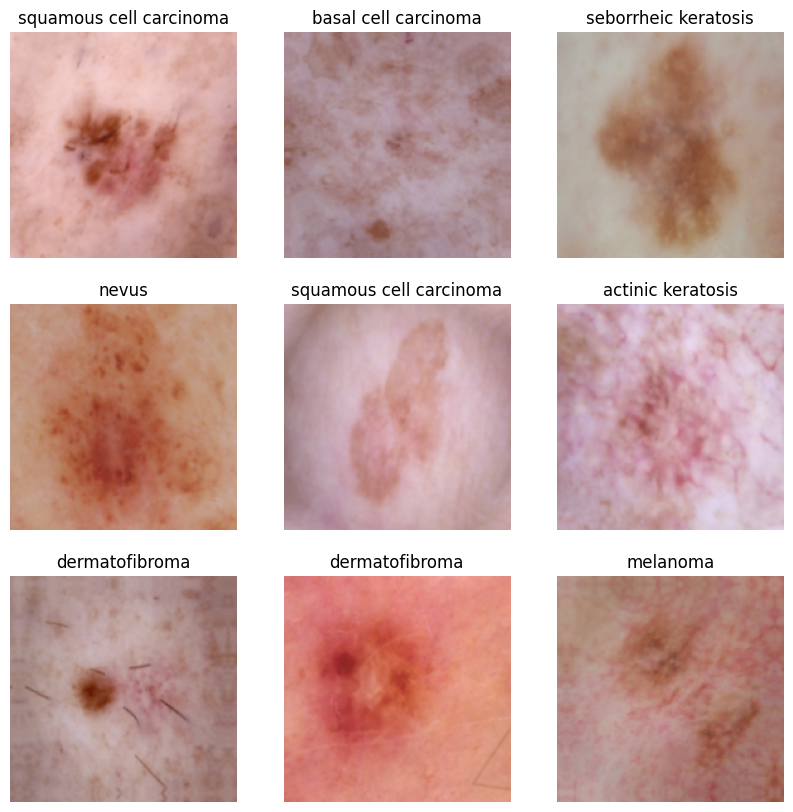

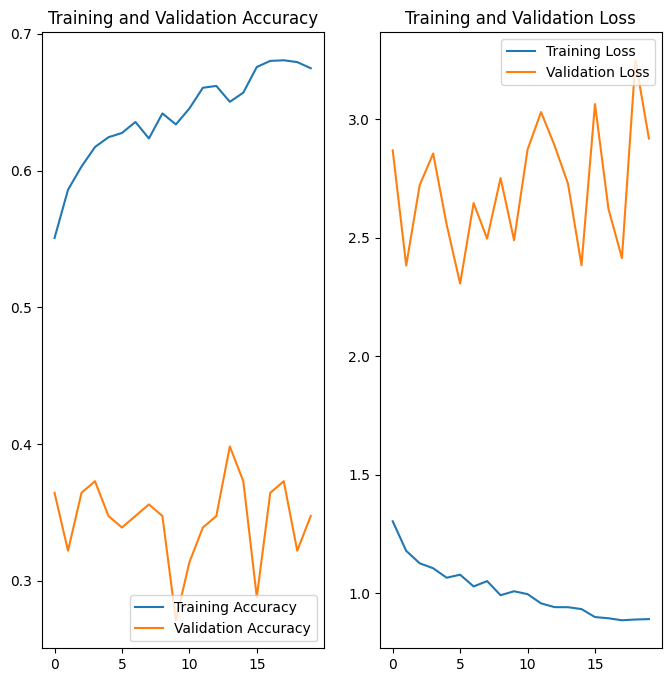

In [21]:
# Visualize data augmentation for one instance
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    augmented_image = data_augmentation(images[i][tf.newaxis, ...], training=True)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")
plt.show()

# Analyze training results after data augmentation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


1.   Training Accuracy has increased linearly while validation accuracy is almost flatten for all the epochs.
2.   Gap between training VS validation accuracy and loss is still very high
3.   Model is still very overfitting.



### Create the model, compile and train the model


In [22]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

num_classes = 9

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),  # Add dropout after the first convolutional block
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),  # Add dropout after the second convolutional block
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),  # Add dropout after the third convolutional block
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Add dropout before the dense layer
    layers.Dense(num_classes, activation='softmax')
])



### Compiling the model

In [23]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 180, 180, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 90, 90, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 90, 90, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 90, 90, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 45, 45, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 22, 22, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 22, 22, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 22, 22, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 11, 11, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 11, 11, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1936)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         247,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 349,561 (1.33 MB)

 Trainable params: 349,561 (1.33 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [25]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 41s 440ms/step - accuracy: 0.1985 - loss: 2.0930 - val_accuracy: 0.1271 - val_loss: 2.1749
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 265ms/step - accuracy: 0.1764 - loss: 2.0629 - val_accuracy: 0.1441 - val_loss: 2.1601
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 17s 245ms/step - accuracy: 0.2503 - loss: 1.9466 - val_accuracy: 0.2797 - val_loss: 2.0953
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 18s 249ms/step - accuracy: 0.3280 - loss: 1.8493 - val_accuracy: 0.2458 - val_loss: 2.1489
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 17s 246ms/step - accuracy: 0.3787 - loss: 1.7275 - val_accuracy: 0.2712 - val_loss: 2.1499
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 19s 265ms/step - accuracy: 0.3882 - loss: 1.6454 - val_accuracy: 0.2797 - val_loss: 2.0395
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 258ms/step - accuracy: 0.4330 - loss: 1.5772 - val_accuracy: 0.2542 - val_loss: 1.9591
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 257ms/step - accuracy: 0.4355 - loss: 1.5538 - val_accu

### Visualizing the results

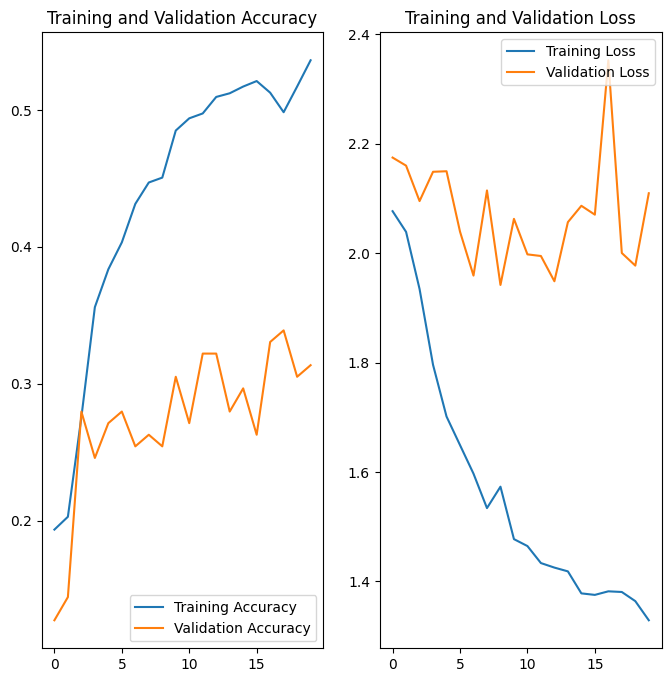

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

1. After adding the dropouts training accuracy is dropped from 68% to 52%.
2. Validation accuracy is dropped to 31%.
3. Gap between training and validation is reduced but still very large for the final model
4. Model is underfitting on both training and validation data.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

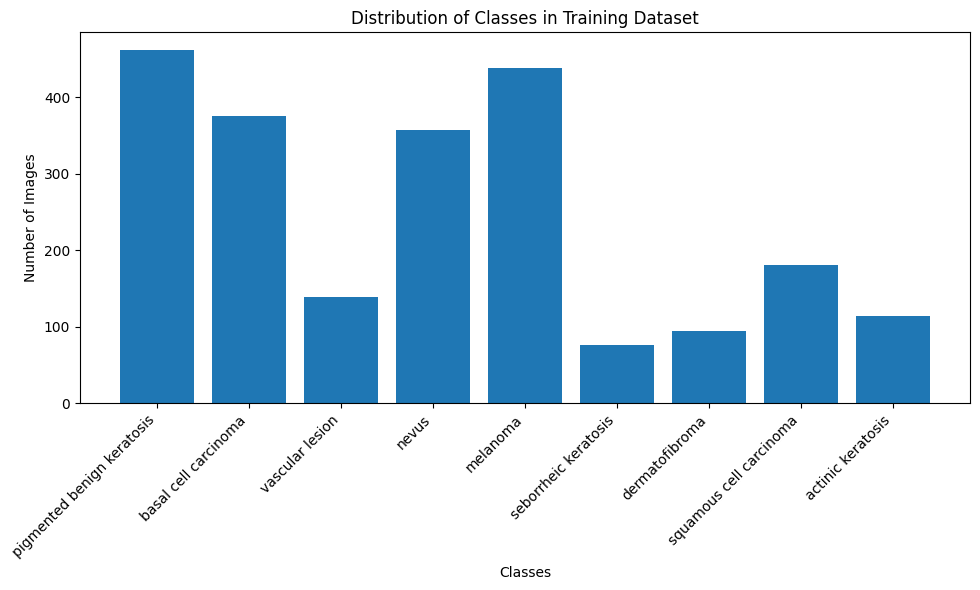

In [27]:
## Your code goes here.
class_counts = {}
for images, labels in train_ds:
  for label in labels:
    class_index = np.argmax(label)  # Find the index of the highest probability
    class_name = class_names[class_index]
    class_counts[class_name] = class_counts.get(class_name, 0) + 1

# Convert the class counts to a list for plotting
classes = list(class_counts.keys())
counts = list(class_counts.values())

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(classes, counts)
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.title("Distribution of Classes in Training Dataset")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
seborrheic keratosis has the least number of samples around 80
#### - Which classes dominate the data in terms proportionate number of samples?
pigmented benign keratosis, melanoma dominate the data. Both of these classes are having more then 400 samples


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [28]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [30]:
path_to_training_dataset="To do"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(os.path.join(str(data_dir_train), i))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x78CE7F709660>: 100%|██████████| 500/500 [00:19<00:00, 26.25 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78CE7C695D20>: 100%|██████████| 500/500 [00:24<00:00, 20.35 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78CE8A376620>: 100%|██████████| 500/500 [00:19<00:00, 25.49 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x78CE8A248D90>: 100%|██████████| 500/500 [01:30<00:00,  5.50 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1007x711 at 0x78CE8A3544C0>: 100%|██████████| 500/500 [01:19<00:00,  6.29 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x78CE8A4F38E0>: 100%|██████████| 500/500 [00:19<00:00, 25.79 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x78CE7C5436D0>: 100%|██████████| 500/500 [00:39<00:00, 12.77 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78CE8A1BAFB0>: 100%|██████████| 500/500 [00:18<00:00, 27.76 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x78CE8A4CD960>: 100%|██████████| 500/500 [00:20<00:00, 24.01 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [31]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [33]:
import glob
path_list = [x for x in glob.glob(os.path.join(str(data_dir_train), '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028389.jpg_289adc1a-0e50-40c7-98f4-f00f16de8b6f.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0025339.jpg_1442a868-7345-45b9-91aa-804e0b9fbabc.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0026277.jpg_c24d0967-ecd6-4aab-bec4-f03e6e80e030.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output/pigmented benign keratosis_original_ISIC_0028404.jpg_8687d1bb-4633-46fa-bd64

In [35]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'pigmen

In [37]:
path_list_new = path_list
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [39]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2.copy()

In [40]:
new_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,1000
nevus,1000
squamous cell carcinoma,1000
vascular lesion,1000
actinic keratosis,1000
melanoma,1000
seborrheic keratosis,1000
basal cell carcinoma,1000
dermatofibroma,1000


So, now we have added 1000 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [41]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [42]:
data_dir_train="/content/gdrive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train"

In [49]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='categorical',
    seed=123,
    validation_split = 0.2,
    subset = "training",
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


#### **Todo:** Create a validation dataset

In [50]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  labels='inferred',
  label_mode='categorical',
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [51]:
num_classes = 9

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [52]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 180, 180, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 90, 90, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 90, 90, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 90, 90, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 45, 45, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 45, 45, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 22, 22, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 22, 22, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 22, 22, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 11, 11, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 11, 11, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 1936)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         247,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 349,561 (1.33 MB)

 Trainable params: 349,561 (1.33 MB)

 Non-trainable params: 0 (0.00 B)

#### **Todo:**  Train your model

In [53]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 79s 250ms/step - accuracy: 0.1198 - loss: 2.1945 - val_accuracy: 0.2572 - val_loss: 1.8407
Epoch 2/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 79s 264ms/step - accuracy: 0.3202 - loss: 1.7719 - val_accuracy: 0.4290 - val_loss: 1.5485
Epoch 3/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 81s 262ms/step - accuracy: 0.4066 - loss: 1.5308 - val_accuracy: 0.4757 - val_loss: 1.3539
Epoch 4/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 76s 241ms/step - accuracy: 0.4458 - loss: 1.4146 - val_accuracy: 0.5069 - val_loss: 1.2981
Epoch 5/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 66s 234ms/step - accuracy: 0.4917 - loss: 1.3167 - val_accuracy: 0.5456 - val_loss: 1.2495
Epoch 6/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 65s 231ms/step - accuracy: 0.5267 - loss: 1.2509 - val_accuracy: 0.6222 - val_loss: 1.0736
Epoch 7/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 67s 239ms/step - accuracy: 0.5770 - loss: 1.1349 - val_accuracy: 0.6146 - val_loss: 1.0128
Epoch 8/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 89s 264ms/step - accuracy: 0.5939 - loss: 1

#### **Todo:**  Visualize the model results

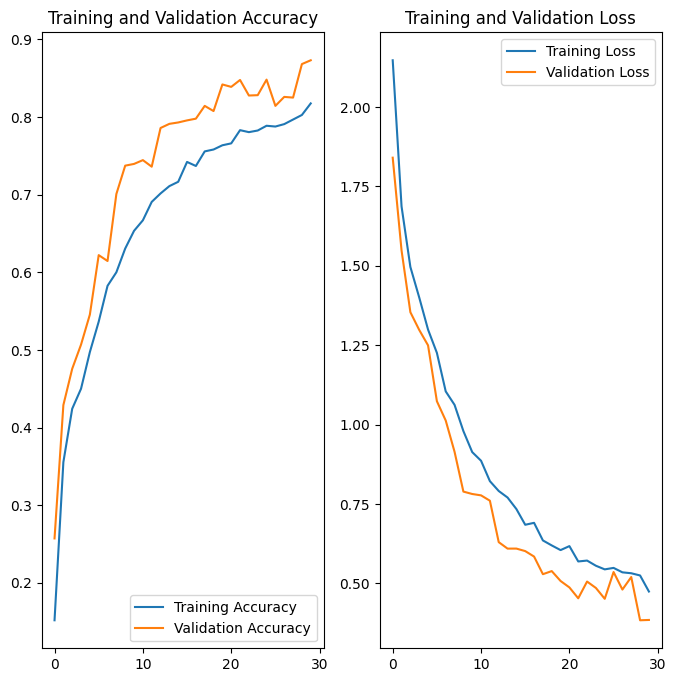

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



# Observations:
1. Training and validation curves for accuracy and loss suggests that accuracy on both training and test data were increasing during all epochs and loss was decreasing.
2. Gap between the training and validation metrics has reduced significantly compared to previous model. Model is neither overfit nor underfit.
3. Validation accuracy is improved significantly after the class rebalancing. Earlier it was 31.36% and now it is 87.32%. After class rebalancing and retraining, the gap between training and validation accuracy has decreased considerably.
4. As per the final validation accuracy our model's performance on unseen data will be very good. Around 87%